In [1]:
import os
import numpy as np
from utils import load_mnist_vgg_dataset_model, plot_mnist

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [2]:
x_train, y_train, x_test, y_test, model = load_mnist_vgg_dataset_model()
all_layer_names = [layer.name for layer in model.model.layers]
model.model.summary()

/home/lzw365/.local/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
2022-04-25 20:28:06.996693: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-25 20:28:07.003881: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-04-25 20:28:07.003901: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your

Model: "MnistVGG"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 32, 32, 1)        0         
 2D)                                                             
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        369

In [3]:
model.get_layer_outputs

[<function keras.backend.function.<locals>.func(model_inputs)>,
 <function keras.backend.function.<locals>.func(model_inputs)>,
 <function keras.backend.function.<locals>.func(model_inputs)>,
 <function keras.backend.function.<locals>.func(model_inputs)>,
 <function keras.backend.function.<locals>.func(model_inputs)>,
 <function keras.backend.function.<locals>.func(model_inputs)>,
 <function keras.backend.function.<locals>.func(model_inputs)>,
 <function keras.backend.function.<locals>.func(model_inputs)>,
 <function keras.backend.function.<locals>.func(model_inputs)>,
 <function keras.backend.function.<locals>.func(model_inputs)>,
 <function keras.backend.function.<locals>.func(model_inputs)>,
 <function keras.backend.function.<locals>.func(model_inputs)>,
 <function keras.backend.function.<locals>.func(model_inputs)>,
 <function keras.backend.function.<locals>.func(model_inputs)>,
 <function keras.backend.function.<locals>.func(model_inputs)>,
 <function keras.backend.function.<local

The following preparation will be done during pre-processing: 

In [4]:
# x_test = x_test[:1000]
# y_test = y_test[:1000]
dataset = x_test
dataset_labels = y_test
del x_train
del y_train

Make sure "python setup_deepeverest_index.py build" is run ahead of time.

In [5]:
layer_name = "activation_12"
layer_id = all_layer_names.index(layer_name)

In [6]:
import ctypes
lib_file = "index/build/lib.linux-x86_64-3.8/deepeverst_index.cpython-38-x86_64-linux-gnu.so"
index_lib = ctypes.CDLL(lib_file)

In [7]:
import math
from utils import *

n_images = len(dataset)
n_partitions= 64
batch_size = 64
ratio = 0.05
bits_per_image = math.ceil(math.log(n_partitions, 2))

In [8]:
layer_result = get_layer_result_by_layer_id(model, dataset, layer_id, batch_size=batch_size)

In [9]:
from DeepEverest import *

rev_act, rev_idx_act, rev_bit_arr, rev_idx_idx, par_low_bound, par_upp_bound = construct_index(
        index_lib=index_lib,
        n_images=n_images,
        ratio=ratio,
        n_partitions=n_partitions,
        bits_per_image=bits_per_image,
        layer_result=layer_result)

The indexes can be persisted to disk with np.save() or pickle.dump() for convenient re-use later.

In [10]:
label_predicted = np.argmax(model.predict(dataset), axis=1)
label_test = np.argmax(dataset_labels, axis=1)

At query time:

In [11]:
misclassified_mask = label_predicted[:1000] != dataset_labels[:1000]
np.where(misclassified_mask)

/tmp/ipykernel_9603/1517277799.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  misclassified_mask = label_predicted[:1000] != dataset_labels[:1000]


(array([0]),)

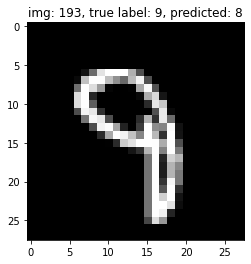

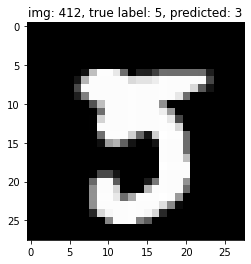

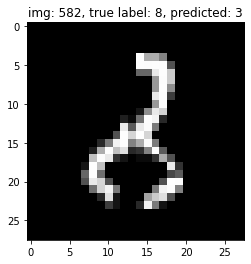

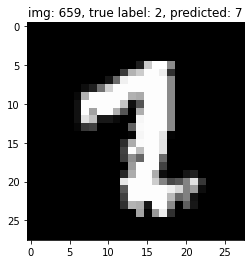

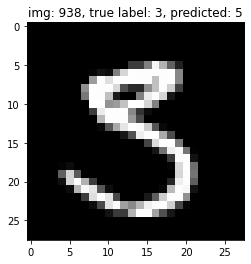

In [12]:
image_ids = [193, 412, 582, 659, 938]
for image_id in image_ids:
    prediction = np.argmax(model.predict(x_test[image_id]), axis=1).item()
    plot_mnist(x_test, label_test, image_id, prediction)

In [13]:
import heapq
def get_topk_activations_given_images(model, dataset, image_ids, layer_name, k):
    res = list()
    image_samples = list()
    for image_sample_id in image_ids:
        image_samples.append(dataset[image_sample_id])
    layer_result_image_samples = model.get_layer_result_by_layer_name(image_samples, layer_name)
    for idx, image_sample_id in enumerate(image_ids):
        heap = list()
        for neuron_idx, activation in np.ndenumerate(layer_result_image_samples[idx]):
            if len(heap) < k:
                heapq.heappush(heap, (activation, neuron_idx))
            elif (activation, neuron_idx) > heap[0]:
                heapq.heapreplace(heap, (activation, neuron_idx))
        res.append(sorted(heap, reverse=True))
    return res

In [14]:
image_ids = [659]
k_global = 20
topk_activations = get_topk_activations_given_images(model, x_test, image_ids, layer_name, k_global)[0]
topk_activations_neurons = [x[1] for x in topk_activations]
topk_activations

[(2.2470708, (1, 1, 374)),
 (1.9390898, (0, 0, 113)),
 (1.9011347, (0, 0, 358)),
 (1.8457984, (1, 0, 335)),
 (1.8241947, (1, 1, 62)),
 (1.7726848, (1, 0, 182)),
 (1.7536622, (1, 1, 129)),
 (1.7496964, (0, 0, 95)),
 (1.7491626, (1, 0, 441)),
 (1.6753774, (1, 1, 177)),
 (1.6667684, (0, 0, 46)),
 (1.6587316, (0, 1, 340)),
 (1.6440474, (0, 1, 285)),
 (1.6398696, (1, 1, 428)),
 (1.6205437, (0, 1, 365)),
 (1.6141273, (0, 1, 461)),
 (1.5758135, (0, 0, 245)),
 (1.558946, (0, 0, 45)),
 (1.5521429, (0, 1, 336)),
 (1.5128994, (0, 1, 379))]

In [15]:
from NeuronGroup import *
image_sample_id = 659
neuron_group = NeuronGroup(model.model, layer_id, neuron_idx_list=topk_activations_neurons[:3])

In [16]:
top_k, exit_msg, is_in_partition_0, n_images_rerun = answer_query_with_guarantee(
                                                        model, dataset, rev_act, rev_idx_act, rev_bit_arr, rev_idx_idx,
                                                        par_low_bound, par_upp_bound, image_sample_id,
                                                        neuron_group, k_global, n_partitions, bits_per_image,
                                                        BATCH_SIZE=batch_size, batch_size=batch_size)
top_k = sorted(top_k)
top_k, exit_msg

image 659, size of neuron group 3
threshold: 0.009084991179406643, max in answer: 1.0652904510498047, images run: 446
threshold: 0.2361185997724533, max in answer: 0.7390391230583191, images run: 879
threshold: 0.25425785779953003, max in answer: 0.7369704842567444, images run: 1320
threshold: 0.4669073820114136, max in answer: 0.648984968662262, images run: 1707
threshold: 0.5761292576789856, max in answer: 0.648984968662262, images run: 2125
threshold: 0.7417832016944885, max in answer: 0.648984968662262, images run: 2537
======================= NTA exited =======================


([(-0.64898497, 8043),
  (-0.6488453, 3073),
  (-0.63240474, 2915),
  (-0.6309901, 9505),
  (-0.6308845, 7985),
  (-0.61490285, 9664),
  (-0.57323945, 1941),
  (-0.57080907, 9637),
  (-0.5610424, 1903),
  (-0.5584375, 3166),
  (-0.5519714, 468),
  (-0.536307, 5649),
  (-0.5042956, 667),
  (-0.3780876, 7902),
  (-0.37677968, 3055),
  (-0.37317902, 5655),
  (-0.3371267, 4176),
  (-0.32671073, 4199),
  (-0.15818696, 3808),
  (0.0, 659)],
 'termination: images run: 2537')

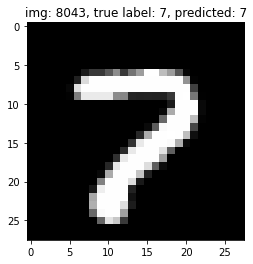

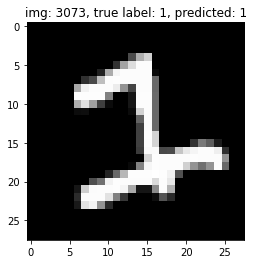

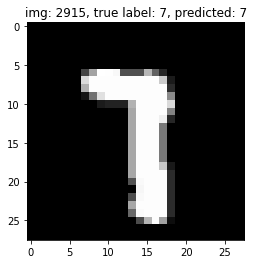

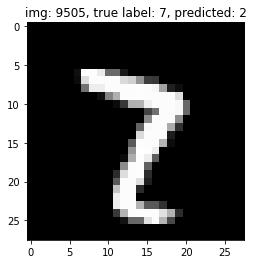

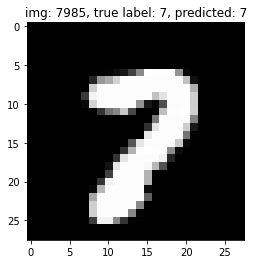

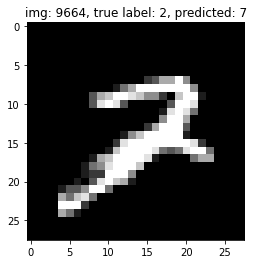

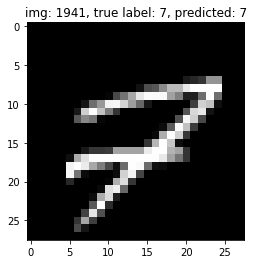

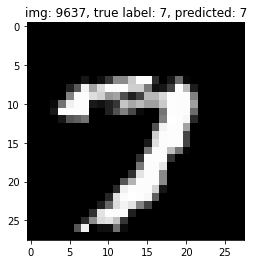

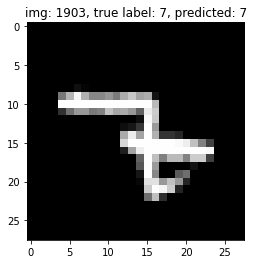

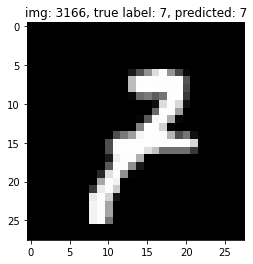

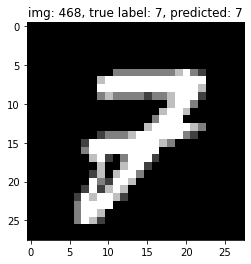

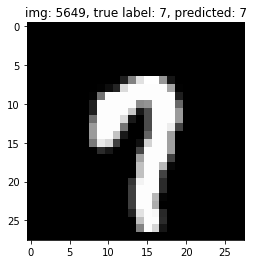

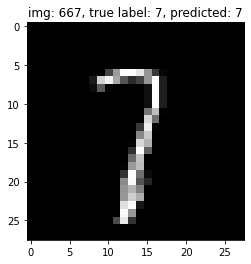

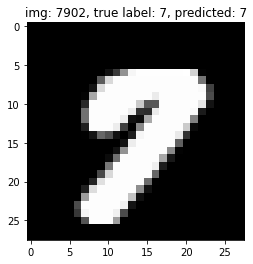

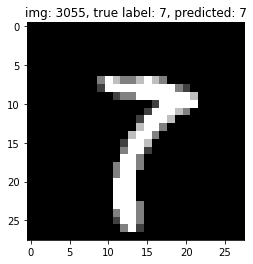

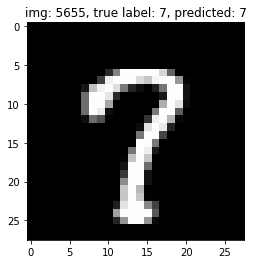

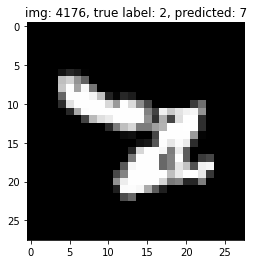

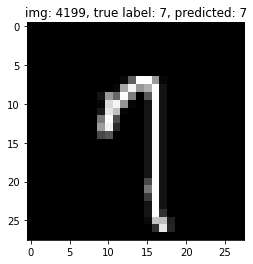

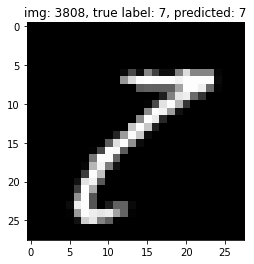

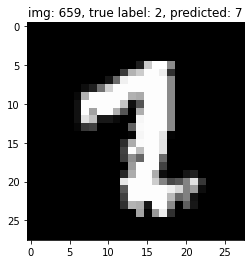

In [17]:
for neg_dist, image_id in top_k:
    prediction = np.argmax(model.predict(x_test[image_id]), axis=1).item()
    plot_mnist(x_test, label_test, image_id, prediction)

In [18]:
def predict_2_as_7(image_id):
    return label_predicted[image_id] == 7 and label_test[image_id] == 2

def predict_7_as_7(image_id):
    return label_predicted[image_id] == 7 and label_test[image_id] == 7

def predict_2_as_2(image_id):
    return label_predicted[image_id] == 2 and label_test[image_id] == 2

def predict_7_as_2(image_id):
    return label_predicted[image_id] == 2 and label_test[image_id] == 7

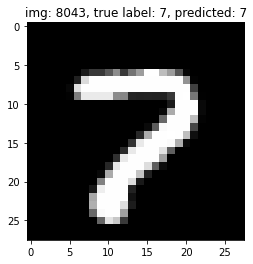

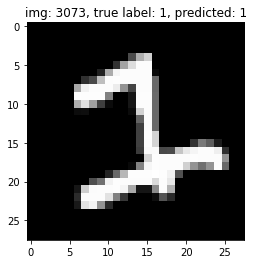

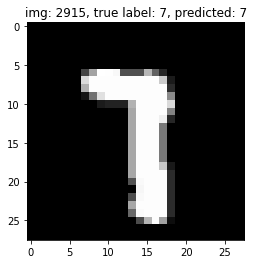

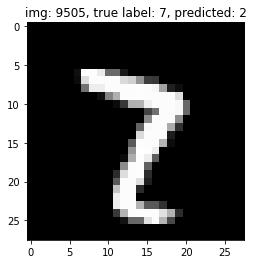

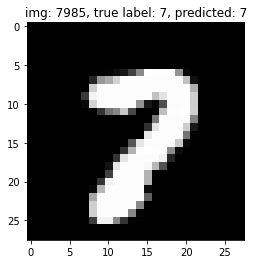

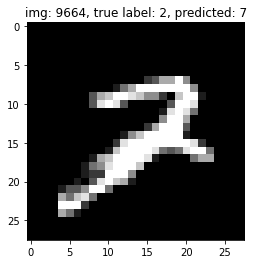

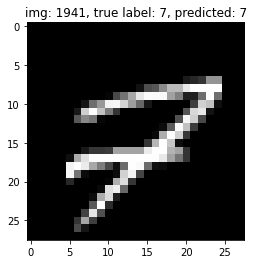

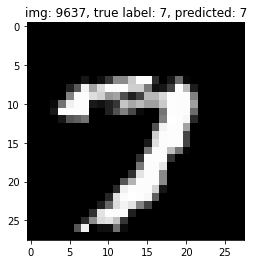

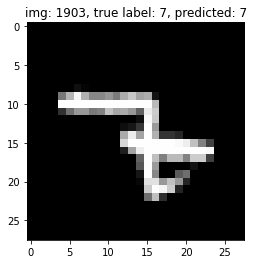

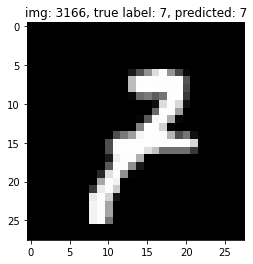

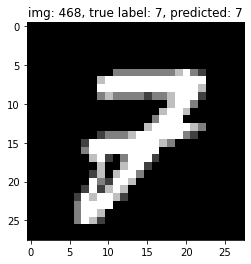

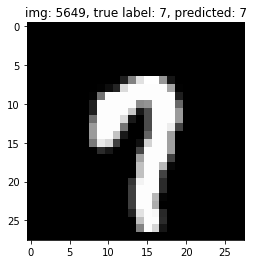

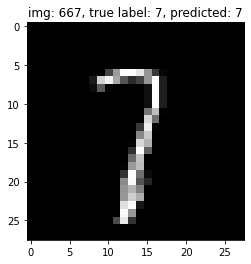

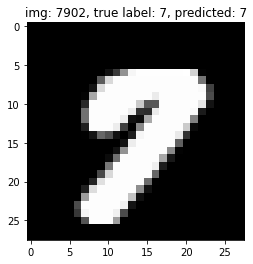

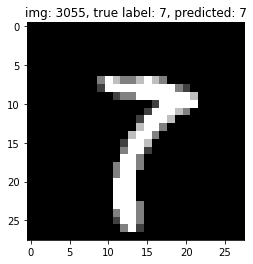

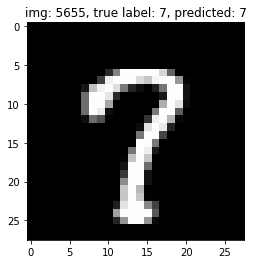

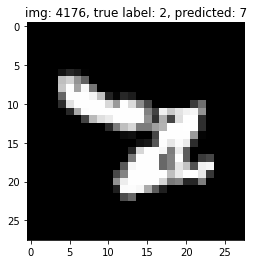

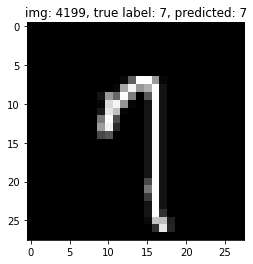

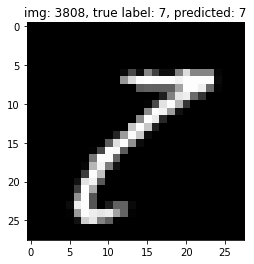

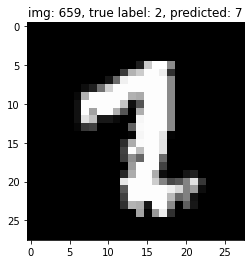

In [19]:
for neg_dist, image_id in top_k:
    prediction = np.argmax(model.predict(x_test[image_id]), axis=1).item()
    plot_mnist(dataset, label_test, image_id, prediction)

In [20]:
seven_as_two = -1
two_as_seven = -1
two_as_two = -1
seven_as_seven = -1
for image_id in range(x_test.shape[0]):
    if seven_as_two < 0 and predict_7_as_2(image_id):
        seven_as_two = image_id
    if two_as_seven < 0 and predict_2_as_7(image_id):
        two_as_seven = image_id
    if two_as_two < 0 and predict_2_as_2(image_id):
        two_as_two = image_id
    if seven_as_seven < 0 and predict_7_as_7(image_id):
        seven_as_seven = image_id
    if seven_as_two > 0 and two_as_seven > 0 and two_as_two > 0 and seven_as_seven > 0:
        break

In [21]:
image_ids = [two_as_two, seven_as_seven, two_as_seven, seven_as_two]

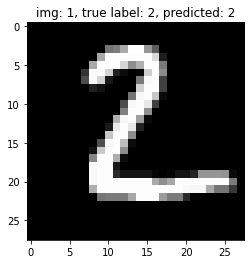

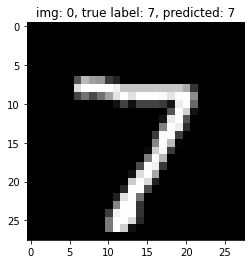

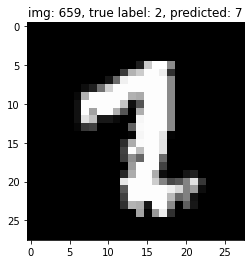

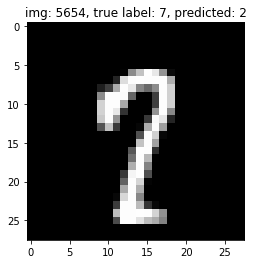

In [22]:
for image_id in image_ids:
    prediction = np.argmax(model.predict(x_test[image_id]), axis=1).item()
    plot_mnist(x_test, label_test, image_id, prediction)

In [23]:
k_global = 20
topk_activations = get_topk_activations_given_images(model, x_test, image_ids, layer_name, k_global)
topk_activations

[[(4.8707347, (1, 0, 224)),
  (4.7479634, (1, 1, 205)),
  (4.7386675, (0, 1, 187)),
  (4.676137, (1, 0, 335)),
  (4.4330816, (0, 1, 39)),
  (4.274835, (1, 0, 322)),
  (4.2448783, (1, 0, 424)),
  (4.10975, (0, 1, 14)),
  (4.077998, (0, 0, 194)),
  (4.0133233, (1, 0, 441)),
  (3.971671, (1, 1, 271)),
  (3.88427, (1, 1, 351)),
  (3.8667443, (0, 1, 61)),
  (3.8560157, (1, 1, 374)),
  (3.802818, (0, 1, 18)),
  (3.7997165, (0, 0, 45)),
  (3.7284117, (1, 0, 234)),
  (3.5818672, (1, 0, 70)),
  (3.4102292, (0, 1, 285)),
  (3.3216052, (0, 1, 287))],
 [(4.7224956, (1, 0, 450)),
  (4.4728017, (0, 0, 358)),
  (4.309977, (0, 1, 236)),
  (4.1930327, (0, 1, 108)),
  (4.1637597, (0, 1, 461)),
  (4.110187, (0, 0, 436)),
  (4.063389, (1, 1, 325)),
  (4.0506167, (0, 0, 4)),
  (4.0463276, (1, 1, 374)),
  (4.0063663, (0, 1, 507)),
  (3.9760296, (1, 1, 311)),
  (3.973668, (1, 1, 177)),
  (3.9360485, (1, 1, 96)),
  (3.9359233, (0, 1, 342)),
  (3.9276059, (1, 0, 16)),
  (3.893428, (1, 1, 62)),
  (3.882738, (0,

In [24]:
neuron_cnt = dict()
for topk_activation in topk_activations:
    for activation, neuron_idx in topk_activation:
        if neuron_idx in neuron_cnt:
            neuron_cnt[neuron_idx] += 1
        else:
            neuron_cnt[neuron_idx] = 1

sorted_neurons = [(k, v) for k, v in sorted(neuron_cnt.items(), key=lambda item: item[1], reverse=True)]
sorted_neurons_idx = [x[0] for x in sorted_neurons]
sorted_neurons

[((1, 1, 374), 4),
 ((1, 0, 335), 3),
 ((1, 0, 441), 3),
 ((0, 0, 45), 3),
 ((0, 1, 285), 3),
 ((1, 1, 62), 3),
 ((1, 0, 224), 2),
 ((0, 1, 187), 2),
 ((1, 0, 424), 2),
 ((0, 1, 14), 2),
 ((0, 1, 18), 2),
 ((1, 0, 234), 2),
 ((0, 0, 358), 2),
 ((0, 1, 461), 2),
 ((1, 1, 177), 2),
 ((0, 0, 46), 2),
 ((1, 0, 182), 2),
 ((0, 0, 113), 2),
 ((1, 1, 129), 2),
 ((0, 1, 365), 2),
 ((1, 1, 205), 1),
 ((0, 1, 39), 1),
 ((1, 0, 322), 1),
 ((0, 0, 194), 1),
 ((1, 1, 271), 1),
 ((1, 1, 351), 1),
 ((0, 1, 61), 1),
 ((1, 0, 70), 1),
 ((0, 1, 287), 1),
 ((1, 0, 450), 1),
 ((0, 1, 236), 1),
 ((0, 1, 108), 1),
 ((0, 0, 436), 1),
 ((1, 1, 325), 1),
 ((0, 0, 4), 1),
 ((0, 1, 507), 1),
 ((1, 1, 311), 1),
 ((1, 1, 96), 1),
 ((0, 1, 342), 1),
 ((1, 0, 16), 1),
 ((0, 1, 170), 1),
 ((0, 0, 104), 1),
 ((0, 0, 95), 1),
 ((0, 1, 340), 1),
 ((1, 1, 428), 1),
 ((0, 0, 245), 1),
 ((0, 1, 336), 1),
 ((0, 1, 379), 1),
 ((1, 1, 261), 1),
 ((0, 0, 52), 1),
 ((1, 1, 226), 1),
 ((1, 0, 22), 1),
 ((1, 0, 369), 1)]

image 5654, size of neuron group 1
threshold: 0.07677435874938965, max in answer: 0.012601375579833984, images run: 151
======================= NTA exited =======================


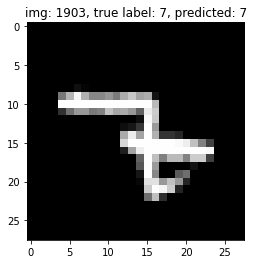

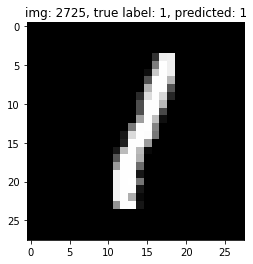

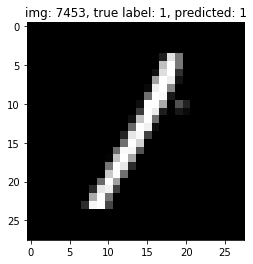

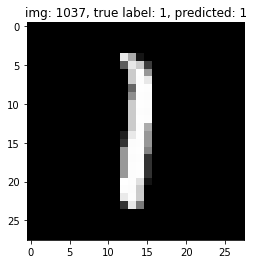

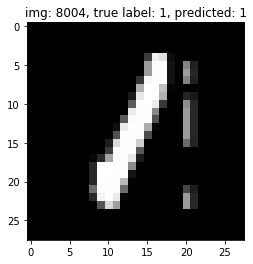

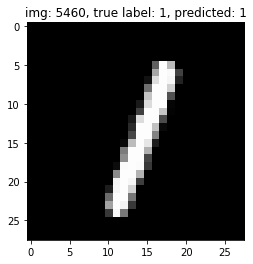

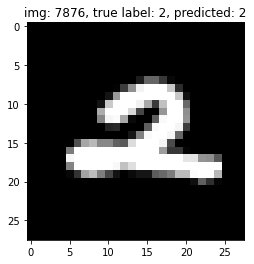

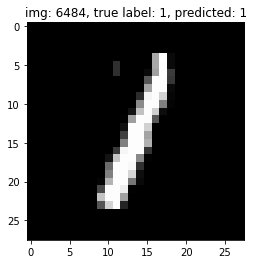

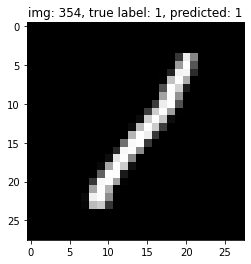

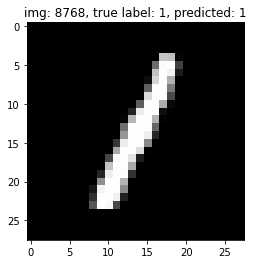

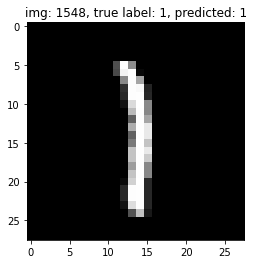

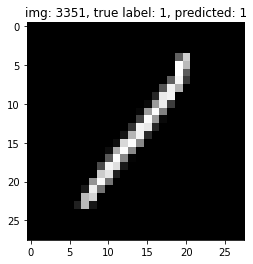

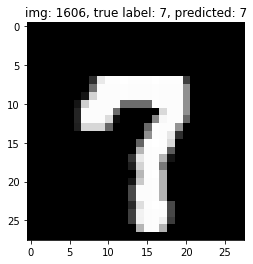

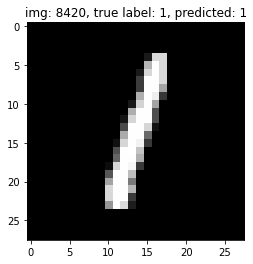

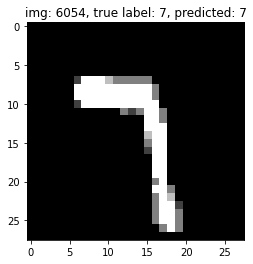

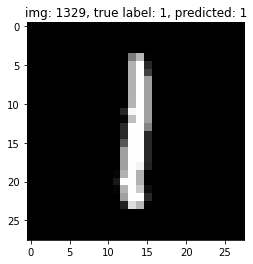

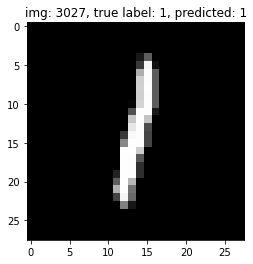

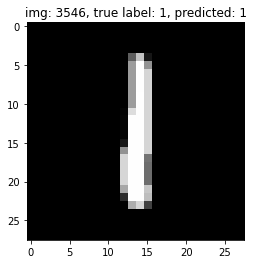

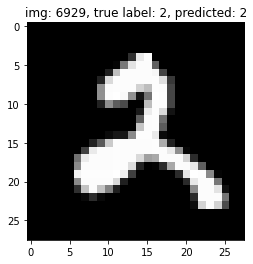

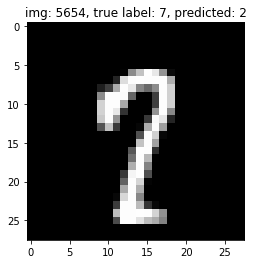

In [25]:
image_sample_id = seven_as_two
layer_id = all_layer_names.index(layer_name)
neuron_group = NeuronGroup(model.model, layer_id, neuron_idx_list=sorted_neurons_idx[:1])
top_k, exit_msg, is_in_partition_0, n_images_run = answer_query_with_guarantee(
                                                        model, dataset, rev_act, rev_idx_act, rev_bit_arr, rev_idx_idx,
                                                        par_low_bound, par_upp_bound, image_sample_id,
                                                        neuron_group, k_global, n_partitions, bits_per_image,
                                                        BATCH_SIZE=batch_size, batch_size=batch_size)
top_k = sorted(top_k)
for neg_dist, image_id in top_k:
    prediction = np.argmax(model.predict(x_test[image_id]), axis=1).item()
    plot_mnist(x_test, label_test, image_id, prediction)

image 5654, size of neuron group 1
threshold: 0.0575411319732666, max in answer: 0.008317232131958008, images run: 151
======================= NTA exited =======================


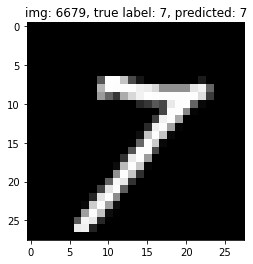

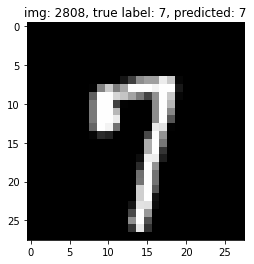

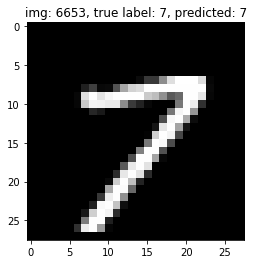

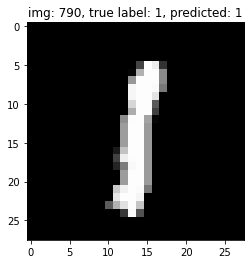

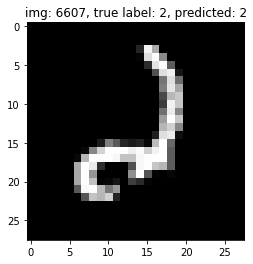

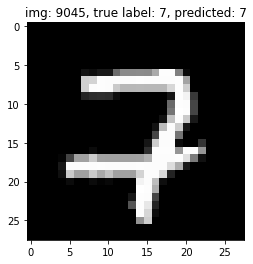

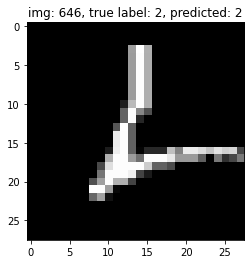

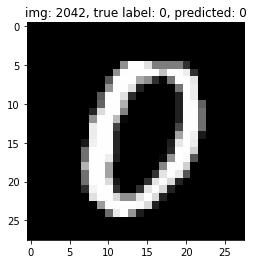

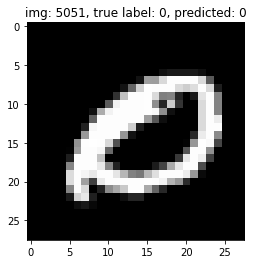

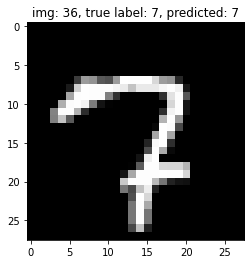

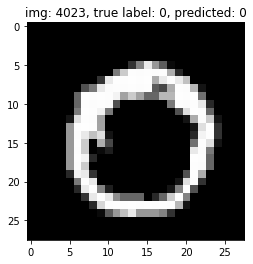

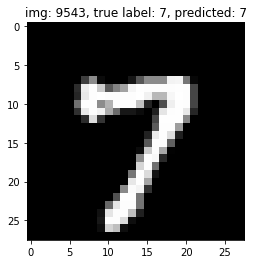

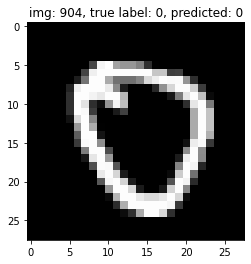

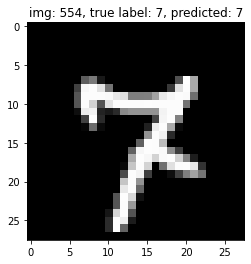

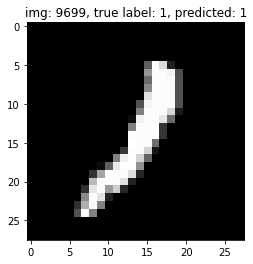

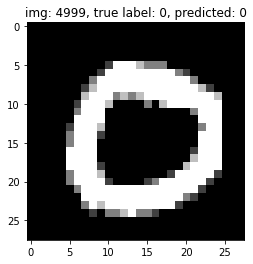

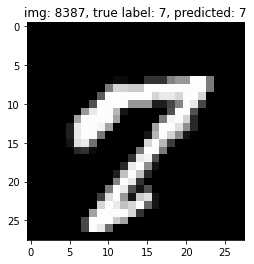

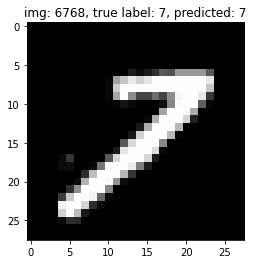

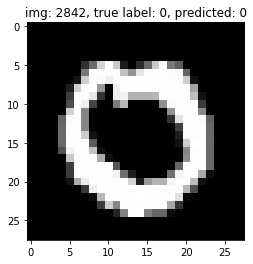

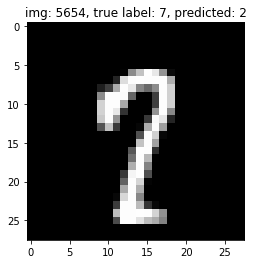

In [26]:
layer_id = all_layer_names.index(layer_name)
neuron_group = NeuronGroup(model.model, layer_id, neuron_idx_list=[(1, 0, 441)])
top_k, exit_msg, is_in_partition_0, n_images_run = answer_query_with_guarantee(
                                                        model, dataset, rev_act, rev_idx_act, rev_bit_arr, rev_idx_idx,
                                                        par_low_bound, par_upp_bound, image_sample_id,
                                                        neuron_group, k_global, n_partitions, bits_per_image,
                                                        BATCH_SIZE=batch_size, batch_size=batch_size)
top_k = sorted(top_k)
for neg_dist, image_id in top_k:
    prediction = np.argmax(model.predict(x_test[image_id]), axis=1).item()
    plot_mnist(x_test, label_test, image_id, prediction)

In [27]:
confusion_activations = [topk_activations[2], topk_activations[3]]
neuron_cnt = dict()
for topk_activation in confusion_activations:
    for activation, neuron_idx in topk_activation:
        if neuron_idx in neuron_cnt:
            neuron_cnt[neuron_idx] += 1
        else:
            neuron_cnt[neuron_idx] = 1
{k: v for k, v in sorted(neuron_cnt.items(), key=lambda item: item[1], reverse=True)}

{(1, 1, 374): 2,
 (0, 0, 113): 2,
 (1, 0, 335): 2,
 (1, 1, 62): 2,
 (1, 1, 129): 2,
 (1, 0, 441): 2,
 (0, 1, 285): 2,
 (0, 1, 365): 2,
 (0, 0, 45): 2,
 (0, 0, 358): 1,
 (1, 0, 182): 1,
 (0, 0, 95): 1,
 (1, 1, 177): 1,
 (0, 0, 46): 1,
 (0, 1, 340): 1,
 (1, 1, 428): 1,
 (0, 1, 461): 1,
 (0, 0, 245): 1,
 (0, 1, 336): 1,
 (0, 1, 379): 1,
 (1, 0, 224): 1,
 (0, 1, 187): 1,
 (1, 0, 234): 1,
 (0, 1, 18): 1,
 (1, 0, 424): 1,
 (1, 1, 261): 1,
 (0, 0, 52): 1,
 (1, 1, 226): 1,
 (1, 0, 22): 1,
 (0, 1, 14): 1,
 (1, 0, 369): 1}

image 5654, size of neuron group 68
threshold: 0.1664077341556549, max in answer: 1.339288592338562, images run: 3909
threshold: 0.4782070517539978, max in answer: 1.3304253816604614, images run: 6302
threshold: 0.6547816395759583, max in answer: 1.3304253816604614, images run: 7708
threshold: 0.7672885656356812, max in answer: 1.3304253816604614, images run: 8479
threshold: 0.9051432013511658, max in answer: 1.3304253816604614, images run: 8956
threshold: 1.01850163936615, max in answer: 1.3304253816604614, images run: 9265
threshold: 1.1428064107894897, max in answer: 1.3304253816604614, images run: 9526
threshold: 1.2024897336959839, max in answer: 1.3304253816604614, images run: 9693
threshold: 1.307955026626587, max in answer: 1.3304253816604614, images run: 9815
threshold: 1.3763253688812256, max in answer: 1.3304253816604614, images run: 9887
======================= NTA exited =======================


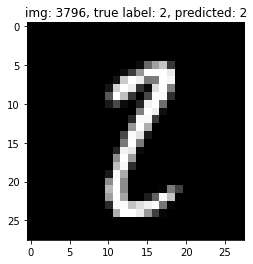

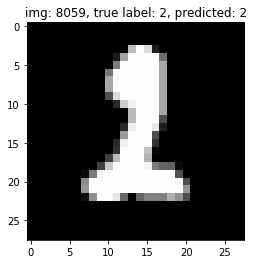

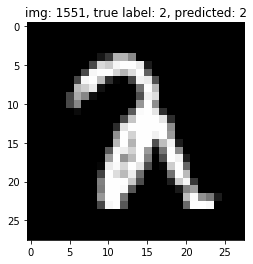

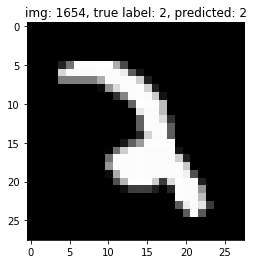

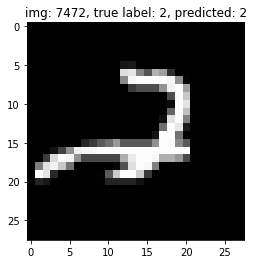

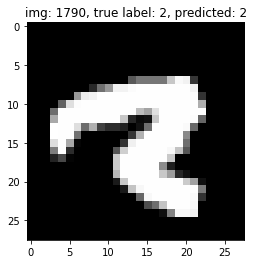

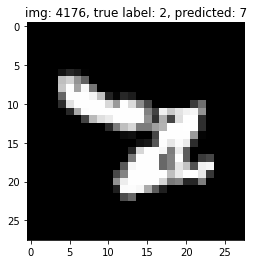

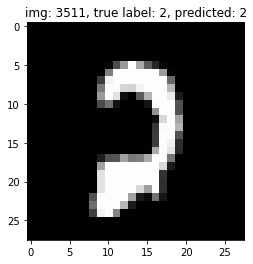

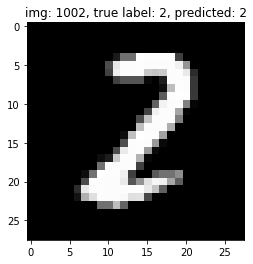

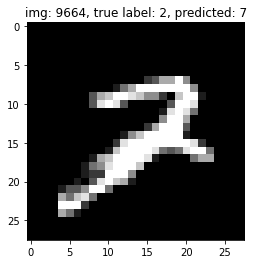

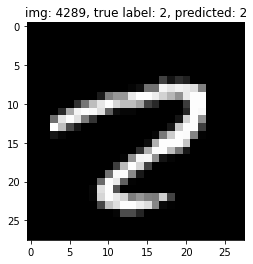

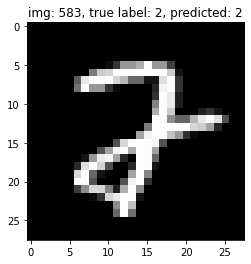

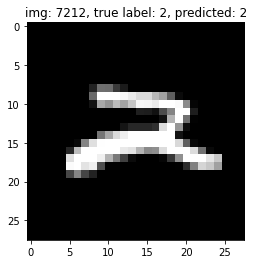

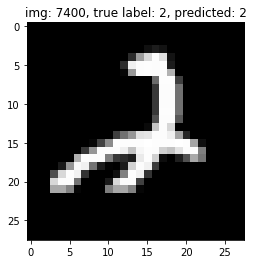

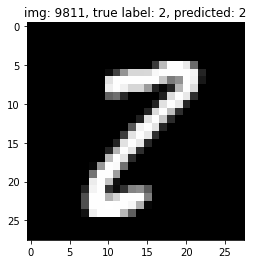

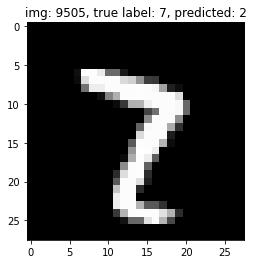

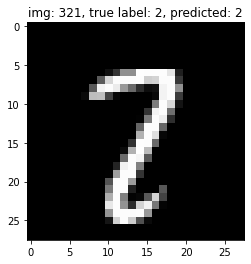

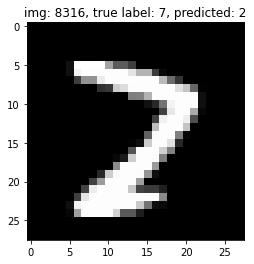

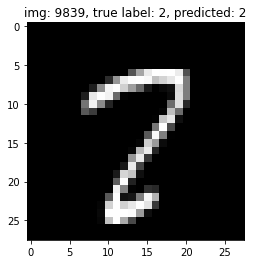

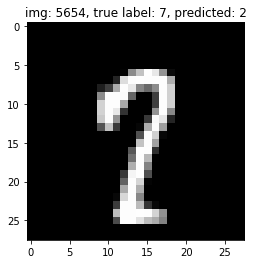

In [28]:
layer_id = all_layer_names.index(layer_name)
neuron_group = NeuronGroup(model.model, layer_id, dimension_ranges=[(1, 2), (1, 2), (62, 130)])
top_k, exit_msg, is_in_partition_0, n_images_run = answer_query_with_guarantee(
                                                        model, dataset, rev_act, rev_idx_act, rev_bit_arr, rev_idx_idx,
                                                        par_low_bound, par_upp_bound, image_sample_id,
                                                        neuron_group, k_global, n_partitions, bits_per_image,
                                                        BATCH_SIZE=batch_size, batch_size=batch_size)
top_k = sorted(top_k)
for neg_dist, image_id in top_k:
    prediction = np.argmax(model.predict(x_test[image_id]), axis=1).item()
    plot_mnist(x_test, label_test, image_id, prediction)

In [29]:
model.get_layer_outputs

[<function keras.backend.function.<locals>.func(model_inputs)>,
 <function keras.backend.function.<locals>.func(model_inputs)>,
 <function keras.backend.function.<locals>.func(model_inputs)>,
 <function keras.backend.function.<locals>.func(model_inputs)>,
 <function keras.backend.function.<locals>.func(model_inputs)>,
 <function keras.backend.function.<locals>.func(model_inputs)>,
 <function keras.backend.function.<locals>.func(model_inputs)>,
 <function keras.backend.function.<locals>.func(model_inputs)>,
 <function keras.backend.function.<locals>.func(model_inputs)>,
 <function keras.backend.function.<locals>.func(model_inputs)>,
 <function keras.backend.function.<locals>.func(model_inputs)>,
 <function keras.backend.function.<locals>.func(model_inputs)>,
 <function keras.backend.function.<locals>.func(model_inputs)>,
 <function keras.backend.function.<locals>.func(model_inputs)>,
 <function keras.backend.function.<locals>.func(model_inputs)>,
 <function keras.backend.function.<local